# CSC-6621: Final Project 

### Topic: Predicting Patient Readmission Rates using Random Forests and Gradient Boosting
**Team Members:** Sumedha Sanjeev, Ethan Traas, Ben Paulson<br/>
**Professor:** Dr. Berisha

In [175]:
import pandas as pd
import numpy as np
from tqdm import tqdm

## Part 1: Getting and Analyzing the Data
As mentioned in our official proposal for exploring this domain, this data comes from [data.cms.gov](https://data.cms.gov/provider-data/dataset/9n3s-kdb3#data-table), formally named "The Center of Medicare and Medicaid". The following description is provided by CMS as part of the Hospital Readmissions Reduction Program:
```text
In October 2012, CMS began reducing Medicare payments for subsection(d) hospitals with excess readmissions under the Hospital Readmissions Reduction Program (HRRP). Excess readmissions are measured by a ratio, calculated by dividing a hospital's predicted rate of readmissions for heart attack (AMI), heart failure (HF), pneumonia, chronic obstructive pulmonary disease (COPD), hip/knee replacement (THA/TKA), and coronary artery bypass graft surgery (CABG) by the expected rate of readmissions, based on an average hospital with similar patients.
```

The data is provided in a CSV file, which we will download and explore in the following `Part 1` section. It is a public dataset, and this is the data description:
* **Released:** December 10, 2020
* **Last Updated:** July 31, 2024
* **Rows:** 18774
* **Features (12):**
    * Facility Name
    * Facility ID
    * State
    * Measure Name
    * Number of Discharges
    * Footnote
    * Excess Readmission Ratio
    * Predicted Readmission Rate
    * Expected Readmission Rate
    * Number of Readmissions
    * Start Date
    * End Date



In [176]:
data = pd.read_csv('raw-data/FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv')
data

,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
0,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HIP-KNEE-HRRP,NaN,NaN,0.8916,3.5325,3.9618,Too Few to Report,07/01/2019,06/30/2022
1,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-HF-HRRP,616.0,NaN,1.1003,23.1263,21.0184,149,07/01/2019,06/30/2022
2,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-AMI-HRRP,274.0,NaN,0.9332,12.9044,13.8283,32,07/01/2019,06/30/2022
3,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-PN-HRRP,404.0,NaN,0.9871,17.0529,17.2762,68,07/01/2019,06/30/2022
4,SOUTHEAST HEALTH MEDICAL CENTER,10001,AL,READM-30-CABG-HRRP,126.0,NaN,0.9517,9.8131,10.3112,11,07/01/2019,06/30/2022
...,...,...,...,...,...,...,...,...,...,...,...,...
18769,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,READM-30-HIP-KNEE-HRRP,NaN,5.0,NaN,NaN,NaN,NaN,07/01/2019,06/30/2022
18770,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,READM-30-HF-HRRP,NaN,1.0,NaN,NaN,NaN,NaN,07/01/2019,06/30/2022
18771,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,READM-30-COPD-HRRP,NaN,5.0,NaN,NaN,NaN,NaN,07/01/2019,06/30/2022
18772,TRINITY REGIONAL HOSPITAL SACHSE,670319,TX,READM-30-CABG-HRRP,NaN,5.0,NaN,NaN,NaN,NaN,07/01/2019,06/30/2022


In [177]:
print(data.dtypes)

Facility Name                  object
Facility ID                     int64
State                          object
Measure Name                   object
Number of Discharges          float64
Footnote                      float64
Excess Readmission Ratio      float64
Predicted Readmission Rate    float64
Expected Readmission Rate     float64
Number of Readmissions         object
Start Date                     object
End Date                       object
dtype: object


In [178]:
print(data.describe())


         Facility ID  Number of Discharges     Footnote  \
count   18774.000000           8094.000000  6697.000000   
mean   261506.077661            244.251915     3.147230   
std    163743.437584            227.648660     2.084349   
min     10001.000000              0.000000     1.000000   
25%    110086.000000            105.000000     1.000000   
50%    250049.000000            176.000000     5.000000   
75%    390113.000000            308.000000     5.000000   
max    670319.000000           4994.000000     7.000000   

       Excess Readmission Ratio  Predicted Readmission Rate  \
count              12077.000000                12077.000000   
mean                   1.001776                   15.098235   
std                    0.077018                    5.480391   
min                    0.615900                    1.927900   
25%                    0.958000                   12.436800   
50%                    0.997800                   16.485500   
75%                    1.04

## Part 2: Preprocessing the Data
Because this data is supplied from a variety of sources across different hostpitals, it is not perfectly formatted yet in order to be used for machine learning. Therefore, we will need to preprocess the data before we can use it to train a model. The following steps will be taken to preprocess the data:
* General data cleaning
    * Remove leading "READM-30-" and trailing "-HRRP" from `Measure Name`
    * Make a new column `Length of Stay` from `Start Date` and `End Date`
* Handling missing/unhelpful values
    * Drop columns with too many missing values
    * Drop columns that are not useful (`Start Date`, `End Date` are all the same)
* Encode categorical variables
    * `Facility Name`, `State`, `Measure Name`
* Standardize numerical variables (0-1)
    * `Number of Discharges`, `Excess Readmission Ratio`, `Predicted Readmission Rate`, `Expected Readmission Rate`, `Number of Readmissions`
* Define the target variable
    * **Target:** `Predicted Readmission Rate`


#### Part 2.1: General Data Cleaning

In [179]:
# Cleaning the Measure Name column
data['Measure Name'] = data['Measure Name'].str.replace('READM-30-', '')
data['Measure Name'] = data['Measure Name'].str.replace('-HRRP', '')

# Determining the length of stay
data['Length of Stay'] = pd.to_datetime(data['End Date']) - pd.to_datetime(data['Start Date'])
data['Length of Stay'] = data['Length of Stay'].dt.days

#### Part 2.2: Remove Unhelpful Data
* `StartDate` and `EndDate` are the same, so we can drop one of them
* `Facility Name` is captured numerically by `Facility ID`

In [180]:
# Drop the `Start Date` and `End Date` and 'Facility Name' columns
data = data.drop(columns=['Start Date', 'End Date', 'Facility Name'])

#### Part 2.3: Encode Categorical Variables

In [181]:
# Encode categorical columns (Facility Name, State, Measure Name)
data = pd.get_dummies(data, columns=['State', 'Measure Name'])

#### Part 2.4: Standardize Numerical Variables

In [182]:
# Standardize numerical values; 0-1 (Number of Discharges, Excess Readmission Ratio, Predicted Readmission Rate, Expected Readmission Rate, Number of Readmissions)

# Convert any non-numeric values in above columns to NaN
data['Number of Discharges'] = pd.to_numeric(data['Number of Discharges'], errors='coerce')
data['Excess Readmission Ratio'] = pd.to_numeric(data['Excess Readmission Ratio'], errors='coerce')
data['Predicted Readmission Rate'] = pd.to_numeric(data['Predicted Readmission Rate'], errors='coerce')
data['Expected Readmission Rate'] = pd.to_numeric(data['Expected Readmission Rate'], errors='coerce')
data['Number of Readmissions'] = pd.to_numeric(data['Number of Readmissions'], errors='coerce')

# Standardize
data['Number of Discharges'] = (data['Number of Discharges'] - data['Number of Discharges'].min()) / (data['Number of Discharges'].max() - data['Number of Discharges'].min())
data['Excess Readmission Ratio'] = (data['Excess Readmission Ratio'] - data['Excess Readmission Ratio'].min()) / (data['Excess Readmission Ratio'].max() - data['Excess Readmission Ratio'].min())
data['Predicted Readmission Rate'] = (data['Predicted Readmission Rate'] - data['Predicted Readmission Rate'].min()) / (data['Predicted Readmission Rate'].max() - data['Predicted Readmission Rate'].min())
data['Expected Readmission Rate'] = (data['Expected Readmission Rate'] - data['Expected Readmission Rate'].min()) / (data['Expected Readmission Rate'].max() - data['Expected Readmission Rate'].min())
data['Number of Readmissions'] = (data['Number of Readmissions'] - data['Number of Readmissions'].min()) / (data['Number of Readmissions'].max() - data['Number of Readmissions'].min())

#### Part 2.5: Define the Target Variable

In [183]:
# Identify the target variable
data.rename(columns={'Predicted Readmission Rate': 'output'}, inplace=True)

# Drop rows where the target variable is NaN
data = data.dropna(subset=['output'])

#### Part 2.6: Determine What to do with NaN Values

`hit_list` is a list of the columns that have NaN values, as well as the percentage of that data which is NOT NaN
```text
('Number of Discharges', 65.33079407137534),
 ('Footnote', 0.0),
 ('Number of Readmissions', 65.33079407137534)]
 ```

 Depending on the model, we will either keep the NaN values or replace them with the average value of the column. For instance, one of the methods that will be tested (`XGBoost`) supports the interpretation of NaN.

In [184]:
# Identify which columns contain NaN values
hit_list = []
for column_name in list(data.columns):
    data_without_na = data.dropna(subset=[column_name])
    percentage = len(data_without_na) / len(data) * 100
    if percentage != 100:
        hit_list.append((column_name, percentage))

for hit in hit_list:
    if hit[1] < 50:
        data = data.drop(columns=[hit[0]])
    else:
        data[hit[0]] = data[hit[0]].fillna(data[hit[0]].mean())

#### Part 2.7: Get Data in State for SKLearn Models

In [185]:
# Format data for sklearn model training
data.to_csv('cleaned_data.csv', index=False)

In [186]:
len(data)

12077

## Part 3: Baseline Model - Linear Regression

The baseline model we will be using is Linear Regression. This model helps model the relationship between a dependent variable (output) and one or more independent variables (features) by fitting a linear equation to observed data. The goal is to predict the value of the dependent variable based on the values of the independent variables.

To train the linear regression model, the following steps will be taken:
- Split the data into training and testing sets
- Train th Linear Regression model:
    - Use the LinearRegression model from sklearn to fit the data.
    - The model learns the relationship between the features and the target variable by minimizing the sum of squared residuals.
- Evaluate the Model:
    -Evaluate the model using Mean Squared Error (MSE) and R-squared (R²) metrics.
    - MSE is the average of the squares of the errors between the predicted and actual values. A smaller MSE indicates better model performance.
    - R² is the proportion of the variance in the dependent variable that is predictable from the independent variables. An R² value closer to 1 indicates a better fit.

In [187]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#### Part 3.1: Data Setup

In [188]:
data = pd.read_csv('cleaned_data.csv')
data.head()

,Facility ID,Number of Discharges,Excess Readmission Ratio,output,Expected Readmission Rate,Number of Readmissions,Length of Stay,State_AK,State_AL,State_AR,...,State_WA,State_WI,State_WV,State_WY,Measure Name_AMI,Measure Name_CABG,Measure Name_COPD,Measure Name_HF,Measure Name_HIP-KNEE,Measure Name_PN
0,10001,0.050174,0.306231,0.061199,0.054545,0.046298,1095,False,True,False,...,False,False,False,False,False,False,False,False,True,False
1,10001,0.123348,0.538043,0.808504,0.777481,0.203240,1095,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,10001,0.054866,0.352438,0.418642,0.472732,0.030928,1095,False,True,False,...,False,False,False,False,True,False,False,False,False,False
3,10001,0.080897,0.412307,0.576865,0.618870,0.083947,1095,False,True,False,...,False,False,False,False,False,False,False,False,False,True
4,10001,0.025230,0.372987,0.300740,0.323661,0.000000,1095,False,True,False,...,False,False,False,False,False,True,False,False,False,False


In [189]:
# Split the data into training and testing sets
X = data.drop(columns=['output'])
y = data['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### 3.2 Train a Linear Regression Model

In [190]:
# Instantiate and train a Linear Regression Model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [191]:
linear_reg.coef_

array([-2.77826139e-09, -1.14783822e-01,  3.81137066e-01,  9.06342762e-01,
        1.21885923e-01,  8.93729535e-15, -2.55925291e-03, -5.98561223e-04,
        3.09648620e-03, -2.06489621e-03,  2.30892101e-03, -3.06165629e-03,
        3.64550430e-03,  4.24800228e-03, -4.75387242e-03,  1.19641044e-03,
        3.83956249e-04,  4.15883341e-04, -2.12612400e-03, -6.99604830e-03,
        1.89596153e-03, -1.42301407e-03, -9.47893497e-04,  7.49307758e-04,
        8.43596704e-05,  7.34575048e-03, -3.63046136e-03, -1.71113463e-03,
        2.35767247e-04, -9.43216882e-04,  1.27310848e-04,  3.80360797e-03,
       -3.35909406e-03,  7.86650267e-05, -3.33966090e-03, -1.26309216e-03,
       -1.11674051e-03,  1.17116042e-03, -1.18771478e-04,  4.14497666e-03,
        5.25935604e-03,  1.24208925e-03,  8.21033715e-04, -3.48041976e-03,
        9.51273245e-04,  3.65154055e-03,  1.99699546e-03, -1.60885243e-03,
        6.42761096e-04,  1.23586382e-03, -4.47694365e-03,  6.48625862e-04,
        9.16013154e-04, -

In [192]:
# Make model predictions
y_linreg_pred = linear_reg.predict(X_test)

In [193]:
# Evaluate the model
mse = mean_squared_error(y_test, y_linreg_pred)
r2 = r2_score(y_test, y_linreg_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.00037282200819848283
R^2 Score: 0.9913242776325004


    Coefficient                    Feature
0      0.906343  Expected Readmission Rate
1      0.381137   Excess Readmission Ratio
2      0.121886     Number of Readmissions
3      0.007346                   State_MA
4      0.005384                   State_WV
..          ...                        ...
58    -0.004044                   State_WY
59    -0.004477                   State_UT
60    -0.004754                   State_DE
61    -0.006996                   State_ID
62    -0.114784       Number of Discharges

[63 rows x 2 columns]


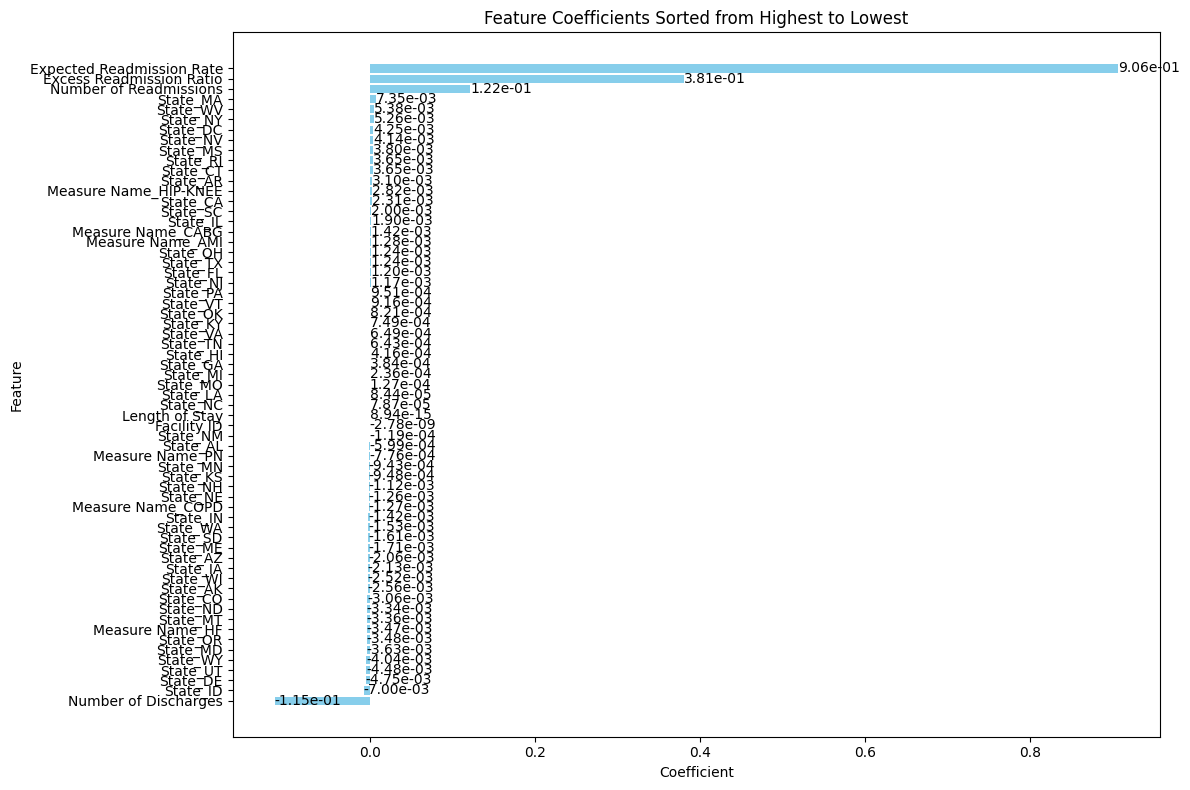

In [194]:
# Assuming X_train is a DataFrame with feature names
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Extract coefficients and feature names
coefficients = linear_reg.coef_
feature_names = X_train.columns

# Pair coefficients with feature names
coef_feature_pairs = list(zip(coefficients, feature_names))

# Sort pairs by coefficient values in descending order
sorted_coef_feature_pairs = sorted(coef_feature_pairs, key=lambda x: x[0], reverse=True)

# Convert to DataFrame for better readability
sorted_df = pd.DataFrame(sorted_coef_feature_pairs, columns=['Coefficient', 'Feature'])

print(sorted_df)

# Plotting the bar chart
plt.figure(figsize=(12, 8))  # Increase figure size
bars = plt.barh(sorted_df['Feature'], sorted_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients Sorted from Highest to Lowest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient on top

# Add text annotations in scientific notation
for bar in bars:
    plt.text(
        bar.get_width(),  # x-coordinate
        bar.get_y() + bar.get_height() / 2,  # y-coordinate
        f'{bar.get_width():.2e}',  # text in scientific notation
        va='center'  # vertical alignment
    )

plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

In [195]:
X_train.drop(columns=['Expected Readmission Rate'], inplace=True)
X_test.drop(columns=['Expected Readmission Rate'], inplace=True)

In [196]:
# Instantiate and train a Linear Regression Model
linear_reg_1 = LinearRegression()
linear_reg_1.fit(X_train, y_train)

# Make model predictions
y_linreg_pred_1 = linear_reg_1.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_linreg_pred_1)
r2 = r2_score(y_test, y_linreg_pred_1)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.002806731245426572
R^2 Score: 0.9346862027722797


Expected Readmission Rate had a coefficient of 0.904, much higher than any of the other features. We removed it to see how it affects performance.

<h5>With Expected Readmission Rate</h5>

- Mean Squared Error (MSE): The value of `0.0003` suggests that the model's predictions have very little error.
- R^2 Score: The value of `0.993` indicates an incredible model performance, showing that the linear regression model does a great job capturing the relationship between the features and the target variable effectively.

<h5>Without Expected Readmission Rate</h5>

- Mean Squared Error (MSE): The value of `0.0030` suggests that the model's predictions doesn't have very much error at all.
- R^2 Score: The value of `0.928` indicates a very good model performance, showing that the linear regression model does a good job capturing the relationship between the features and the target variable effectively.

## Part 4: Random Forest Predictions

The improved and optimized model that we will be testing for this domain is the `Random Forest`. If you don't know what the Random Forest model is, you can read more about it [here](https://en.wikipedia.org/wiki/Random_forest). In summary, the Random Forest model is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

**The following steps will be taken to train and test the Random Forest model:**
* Split the data into training and testing sets
* Train the Random Forest model
    * Use the `RandomForestRegressor` model from `sklearn`
    * Hyperparameter `n_estimators` will be tuned. This hyperparameter is responsible for the number of trees in the forest. The larger the number of trees, the better the model will be but the longer it will take to run. Another downside of increasing the number of trees is that the model may overfit.
    * Hyperparameter `max_depth` will be tuned. This hyperparameter is responsible for the maximum depth of the tree. The deeper the tree, the more splits it has and it captures more information about the data. However, the deeper the tree, the more likely it is to overfit.
* Results will be evaluated
    * Output is `MSE` since this is a regression model. `MSE` is the mean squared error, which is the average of the squares of the errors. The larger the number, the larger the error. A good value to shoot for, given our output is a percentage, is 0.01 or less.

A random forest model was chosen because it is a robust model that can handle a large number of features and is less likely to overfit than a single decision tree. It is also a good model to use for regression problems because it handles non-linear relationships by the combination of the linear nature of decision trees.


In [197]:
# Import random forest from sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### Part 4.1: Data Setup

In [198]:
data = pd.read_csv('cleaned_data.csv')

In [199]:
# Split the data into training and testing sets
X = data.drop(columns=['output'])
y = data['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Part 4.2: Train a Random Forest Model

In [200]:
# Instantiate and train a Random Forest Model
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [201]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 1.7535813753829712e-05
R^2 Score: 0.9996035633386569


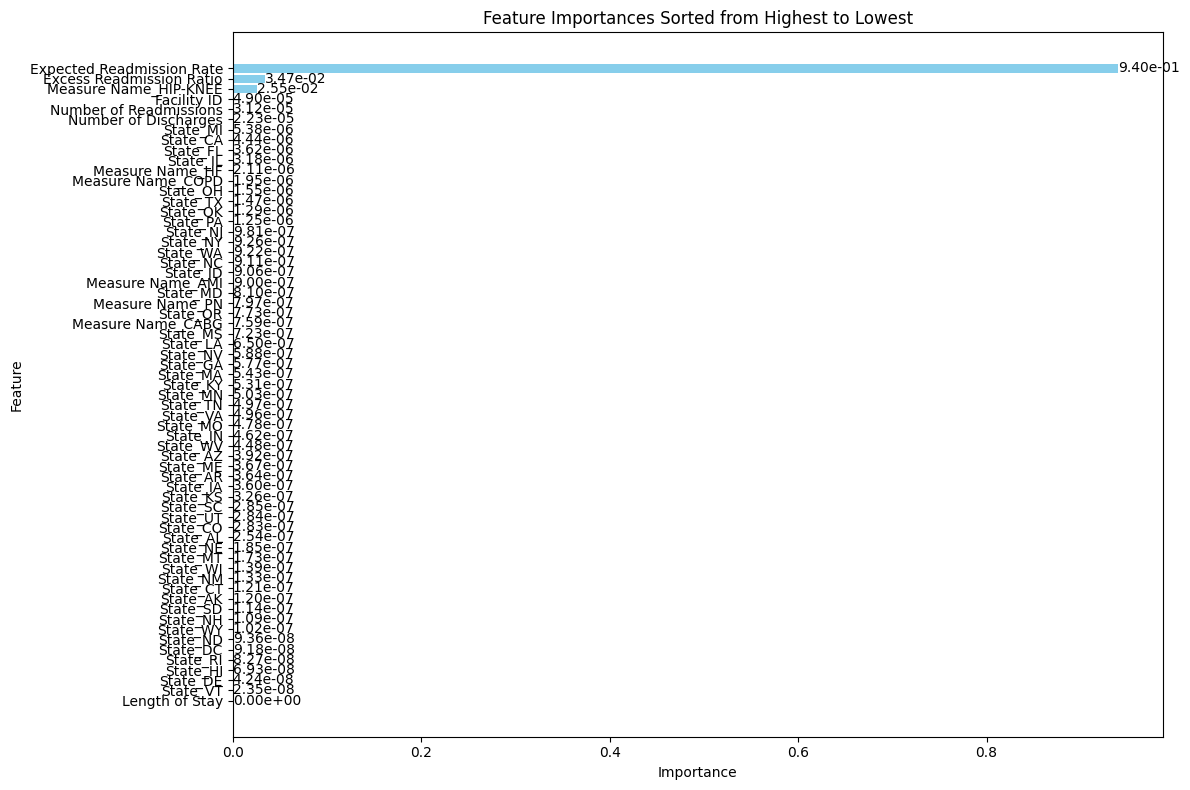

In [202]:
# Extract feature importances and feature names
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Pair feature importances with feature names
importance_feature_pairs = list(zip(feature_importances, feature_names))

# Sort pairs by importance values in descending order
sorted_importance_feature_pairs = sorted(importance_feature_pairs, key=lambda x: x[0], reverse=True)

# Convert to DataFrame for better readability
sorted_df = pd.DataFrame(sorted_importance_feature_pairs, columns=['Importance', 'Feature'])

# Plotting the bar chart
plt.figure(figsize=(12, 8))  # Increase figure size
bars = plt.barh(sorted_df['Feature'], sorted_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances Sorted from Highest to Lowest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top

# Add text annotations in scientific notation
for bar in bars:
    plt.text(
        bar.get_width(),  # x-coordinate
        bar.get_y() + bar.get_height() / 2,  # y-coordinate
        f'{bar.get_width():.2e}',  # text in scientific notation
        va='center'  # vertical alignment
    )

plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

In [203]:
X_train.drop(columns=['Expected Readmission Rate'], inplace=True)
X_test.drop(columns=['Expected Readmission Rate'], inplace=True)

In [204]:
# Instantiate and train a Random Forest Model
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.002714794411456965
R^2 Score: 0.9386259430090108


Expected Readmission Rate had a feature importance of 0.937, much higher than any of the other features. We removed it to see how it affects performance.

<h5>With Expected Readmission Rate</h5>

- Mean Squared Error (MSE): The value of `1.088e-5` suggests that the model's predictions has almost no error.
- R^2 Score: The value of `0.9997` indicates a near perfect model performance, suggesting that the random forest regressor model is capturing the relationship between the features and the target variable extremely well.

<h5>Without Expected Readmission Rate</h5>

- Mean Squared Error (MSE): The value of `0.0024` suggests that the model's predictions still has very low error.
- R^2 Score: The value of `0.947` indicates a very good model performance, showing that the linear regression model does a good job capturing the relationship between the features and the target variable effectively.

#### Part 4.3: Hyperparameter Tune via Grid Search
Given we achieved an MSE of `1.1657932133341314e-05`, we can say that the Random Forest model is a good fit for this data. The next step is to try optimizing this model to achieve better results while visualizing how the mse changes given different parameters. We will use a simple two-level for-loop to iterate through different values of `n_estimators` and `max_depth` to find the best combination of hyperparameters.

The range of values which will be tested are as follows:
```python
n_estimators = [10, 25, 50, 100, 150, 200, 300, 400]
max_depth = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60]
```

In [205]:
n_estimators = [10, 25, 50, 100, 150, 200, 300, 400]
max_depth = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60]

results = []

for n in tqdm(n_estimators):
    for d in max_depth:
        model = RandomForestRegressor(n_estimators=n, max_depth=d)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        results.append((n, d, mse))

100%|██████████| 8/8 [07:19<00:00, 54.88s/it]


In [207]:
# Determine the best hyperparameters
best = min(results, key=lambda x: x[2])
print(f"""
Best hyperparameters:
- n_estimators: {best[0]}
- max_depth: {best[1]}
- mse: {best[2]}
""")


Best hyperparameters:
- n_estimators: 400
- max_depth: 20
- mse: 0.002179963216791013



In [208]:
# Visualize how the MSE changes with different hyperparameters (3D meshgrid, rotatable plot))
import plotly.graph_objects as go

# Create DataFrame
results_df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'mse'])

# Prepare data for 3D plot
X = results_df['n_estimators']
Y = results_df['max_depth']
Z = results_df['mse']

# Create 3D plot
fig = go.Figure(data=[go.Mesh3d(x=X, y=Y, z=Z, color='lightblue', opacity=0.50)], layout=go.Layout(title='MSE vs. Hyperparameters'))

# Color the plot based on mse value
fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='markers', marker=dict(size=12, color=Z, colorscale='Viridis', opacity=0.8)))

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title='Number of Estimators',
        yaxis_title='Max Depth',
        zaxis_title='Mean Squared Error'
    )
)

# Show plot
fig.show()

#### Part 4.4: Random Forest Conclusion

Based on the above results of Grid Search, we see that the best hyperparameters for the Random Forest model are `n_estimators=400` and `max_depth=30`. The MSE for this model is `8.782553467944984e-06`, which is a good value to shoot for given our output is a percentage. This means that the model is able to predict the readmission rate with an error of 0.0008782553467944984, which is a very small error on the scale of 0-1 that our output is on.

Evaluating why these parameters likely were the sweet-spot for accuracy while balancing the number of trees and branches within those trees, I believe that the model was able to capture the complexity of the data while not overfitting. The model was able to generalize well to the test data and predict the readmission rate with a very small error.


## Part 5: Gradient Boosting Predictions

Beyond `Random Forest`, another great application of machine learning to regression problems is `Gradient Boosting`. If you don't know what Gradient Boosting is, you can read more about it [here](https://en.wikipedia.org/wiki/Gradient_boosting). In summary, Gradient Boosting is a machine learning technique for regression and classification problems that produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

To summarize the difference between `Gradient Boosting` and `Random Forests`, the main difference is that `Gradient Boosting` builds trees sequentially, where each tree tries to correct the mistakes of the previous one. On the other hand, `Random Forests` builds trees independently, where each tree is built from a sample of the data.

This section will be an evaluation similar to that seen in `Part 2`, allowing comparison of the two approaches to this domain.

In [ ]:
# TODO

# NOTE: If these models are too good, could make a bigger split
# NOTE: When testing, you should have a validation set
# NOTE: Could try the model without doing feature engineering
# NOTE: After gradient boosting, could do a simple neural network (non-deep) to see if we even need the complex deep learning models